# Grab AI FOR S.E.A - Safety (Saeful Ramadhan, June 17 2019)

![](https://static.wixstatic.com/media/397bed_e0fd4340ff5f40de876b26f0fb7e1f83~mv2.png/v1/fill/w_458,h_458,al_c,q_80,usm_0.66_1.00_0.01/Grab%20EDM_Safety.webp)

## Based on telematics data, how might we detect if the driver is driving dangerously?

Online transportation practically have been a daily basis for many people in S.E.A, it is easy, cheap and flexible to use with many additional benefit like promo (yeay!). Because it is so often, safety have always been a concern for us as a customer. **Grab** as the biggest player in ride-hailing service in S.E.A also must provide all-around experience for customer,not only providing the best price, but also ensure the driving safety rate is high.

With an increasing amount of data this day, A.I and Machine learning plays an important role to deliver an analytical solution for many things, in this competition, we're given the telematics data for each trip and the label if the trip is tagged as dangerous driving, how can we derive a model that can detect dangerous driving trips?


## Dataset

Dataset is given in the form of comma separated value file in several parts. part 0 is the `train` dataset with label in separated file and the rest is data `test`.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from numpy.fft import *
from sklearn.model_selection import cross_val_score,train_test_split
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.style as style 
import eli5
from skopt import BayesSearchCV
from eli5.sklearn import PermutationImportance
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

In [4]:
#Read train dataset and its label
train = pd.read_csv("../Documents/safety/features/part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv")
label = pd.read_csv("../Documents/safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

In competition F.A.Q, there is an information about some bookings with multiple labels in the dataset, so we should cleaning this first.

In [5]:
label['bookingID'].value_counts().head(19)

1391569403991    2
154618822837     2
481036337234     2
919123001348     2
1511828488211    2
970662608932     2
1649267441751    2
515396075694     2
695784702084     2
403726925929     2
1632087572573    2
13               2
395136991308     2
1279900254294    2
1408749273124    2
455266533495     2
1348619731077    2
223338299461     2
901943132350     1
Name: bookingID, dtype: int64

So, there are 18 `bookingID` that duplicated. let's cleaning this first by summing the label. 

In [6]:
label = pd.DataFrame(label.groupby('bookingID')['label'].sum())
label = label.reset_index()
label['bookingID'].value_counts().head()

231928233991     1
970662608993     1
867583393873     1
1554778161247    1
575525617768     1
Name: bookingID, dtype: int64

It looks like, the duplicated label doesn't have any `1` and `1` pair. so, in this case, we assumed the duplicated label with value `1` and `0` to be labelled `1`.

## The Features

In [7]:
train.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059
3,1073741824054,3.900,126.0,3.871543,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409


Basic exploration above tell us the features is grouping with `bookingID`, it contains common features that associated with the sensor in smartphone used by drivers. Let's explore one by one! 

### BookingID :
> This is an ID indicated the trips going on.

### Accuracy :
> From the description it says `accuracy inferred by GPS in meters` , but what actually this means?, after a little bit researching through google, it turns out this feature means the location `range of error`, so smaller the values will be more accurate!.
![](https://www.gps.gov/systems/gps/performance/accuracy/URE-vs-user-accuracy.jpg)

### Bearing :
> GPS bearing in degree, it essentially the compass direction from current location range from 0-360 degrees.

### Acceleration X,Y,Z :
> 3-axis acceleration data from accelerometer sensor measured in m/s^2

### Gyro X,Y,Z :
> 3-axis gyro data from gyroscope sensor measured in rad/s

### Second :
> the time where data point recorded.

### Speed :
> Speed measured by GPS in m/s

At a glance, there is some problem about dataset even more challenging, because :
* Data points taken at random time with different length for every trips
* There is zero information about the device used by drivers.

This makes analyzing dataset even harder, especially when telematics data usually represented as a `signal`.

## Data Exploration

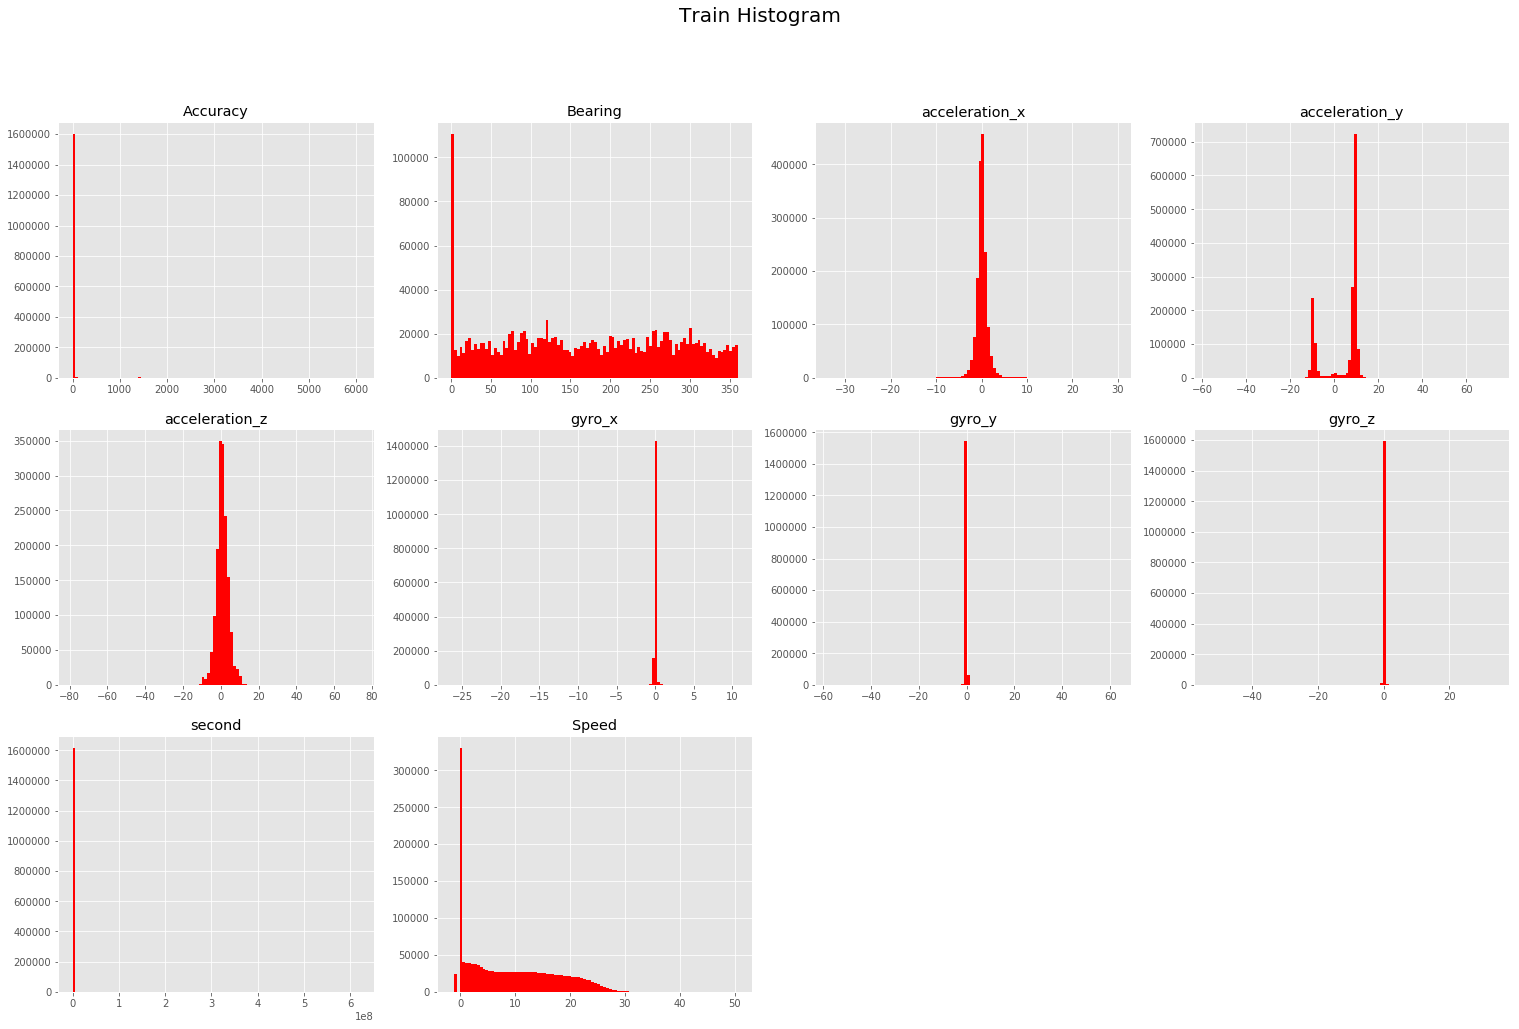

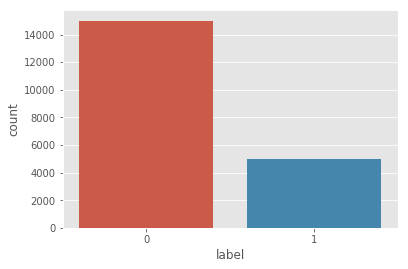

In [8]:
cols = ['Accuracy','Bearing','acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z','second','Speed']
plt.figure(figsize=(26, 16))
plt.suptitle("Train Histogram", fontsize=20)
for i, col in enumerate(cols):
    plt.subplot(3, 4, i + 1)
    plt.hist(train[col], color='red', bins=100)
    plt.title(col)
plt.show()
sns.countplot(label['label'])

Label distribution is unbalanced, it is quite common in binary classification problem, hence its better to use `Stratified` sampling for cross validation strategies. Histogram plot tell us `Bearing` , `Acceleration_y` and `Speed` doesn't follow normal distribution, let's keep this one, we should concern about this if we want to use some gaussian methods in the future.

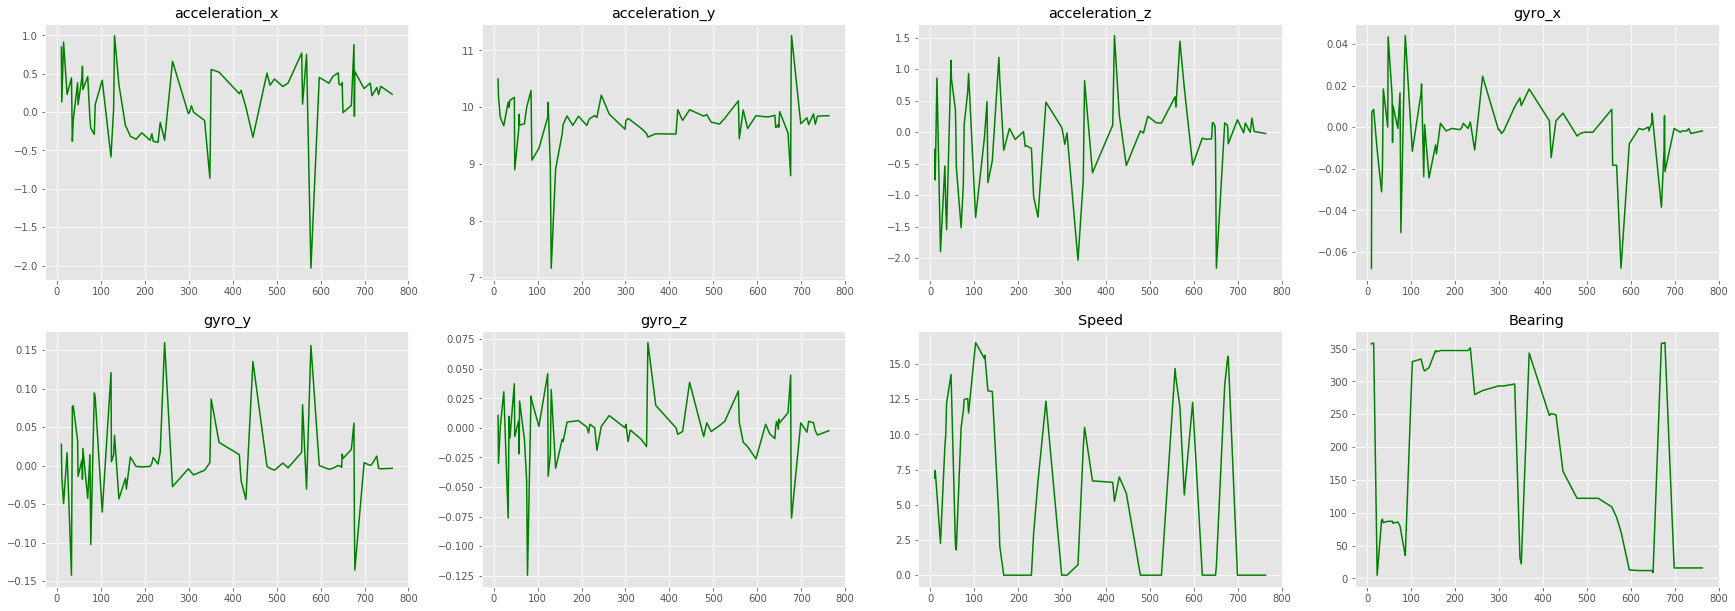

In [9]:
cols = ['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z','Speed','Bearing']
plt.figure(figsize=(30, 16))
#plt.suptitle("Train / Test Line plot", fontsize=20)
for i, col in enumerate(cols):
    plt.subplot(3, 4, i + 1)
    data = train[train['bookingID'] == 111669149733].sort_values(by=['second'])
    plt.plot(data['second'],data[col], color='green')
    plt.title(col)

As we can see, the `signal` is quite noisy and has no trends in it because data points taken at random times and have different length for each trips.

In [10]:
train.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,1.613554e+06,1.613554e+06,1.613554e+06,1.613554e+06,1.613554e+06,1.613554e+06,1.613554e+06,1.613554e+06,1.613554e+06,1.613554e+06,1.613554e+06
mean,8.185688e+11,1.157350e+01,1.689111e+02,6.807467e-02,4.469578e+00,8.985294e-01,-1.754218e-03,4.358774e-04,-2.671857e-04,4.824088e+03,9.009763e+00
std,4.951339e+11,8.665737e+01,1.072641e+02,1.426141e+00,8.129320e+00,3.249632e+00,1.430876e-01,3.460380e-01,1.525665e-01,1.617019e+06,8.106659e+00
min,0.000000e+00,7.500000e-01,0.000000e+00,-3.344084e+01,-5.730359e+01,-7.844842e+01,-2.644802e+01,-5.734489e+01,-5.355445e+01,0.000000e+00,-1.719776e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.087678e-01,-1.995674e+00,-9.265844e-01,-2.686586e-02,-2.983093e-02,-1.867207e-02,2.420000e+02,1.019846e+00
50%,8.074539e+11,4.259000e+00,1.682945e+02,6.130981e-02,9.082103e+00,7.807281e-01,-6.597335e-04,2.746582e-04,-3.051758e-05,5.200000e+02,7.540000e+00
75%,1.254130e+12,8.000000e+00,2.624448e+02,6.344828e-01,9.710000e+00,2.753416e+00,2.333505e-02,3.141879e-02,1.825624e-02,8.630000e+02,1.548176e+01
max,1.709397e+12,6.063000e+03,3.599985e+02,2.961647e+01,7.281000e+01,7.331421e+01,1.068810e+01,6.254202e+01,3.383183e+01,6.193165e+08,5.055000e+01


there is some big jump in `Accuracy` and `second` distribution from 75% to maximum value. Lets we concern to the `Accuracy` first.

### Accuracy & Second VS (Root of sum-of-square acceleration,gyroscope) & Speed


In [11]:
train['acc_tot'] = np.sqrt(train['acceleration_x']**2+train['acceleration_y']**2+train['acceleration_z']**2)
train['gyro_tot'] = np.sqrt(train['gyro_x']**2+train['gyro_y']**2+train['gyro_z']**2)

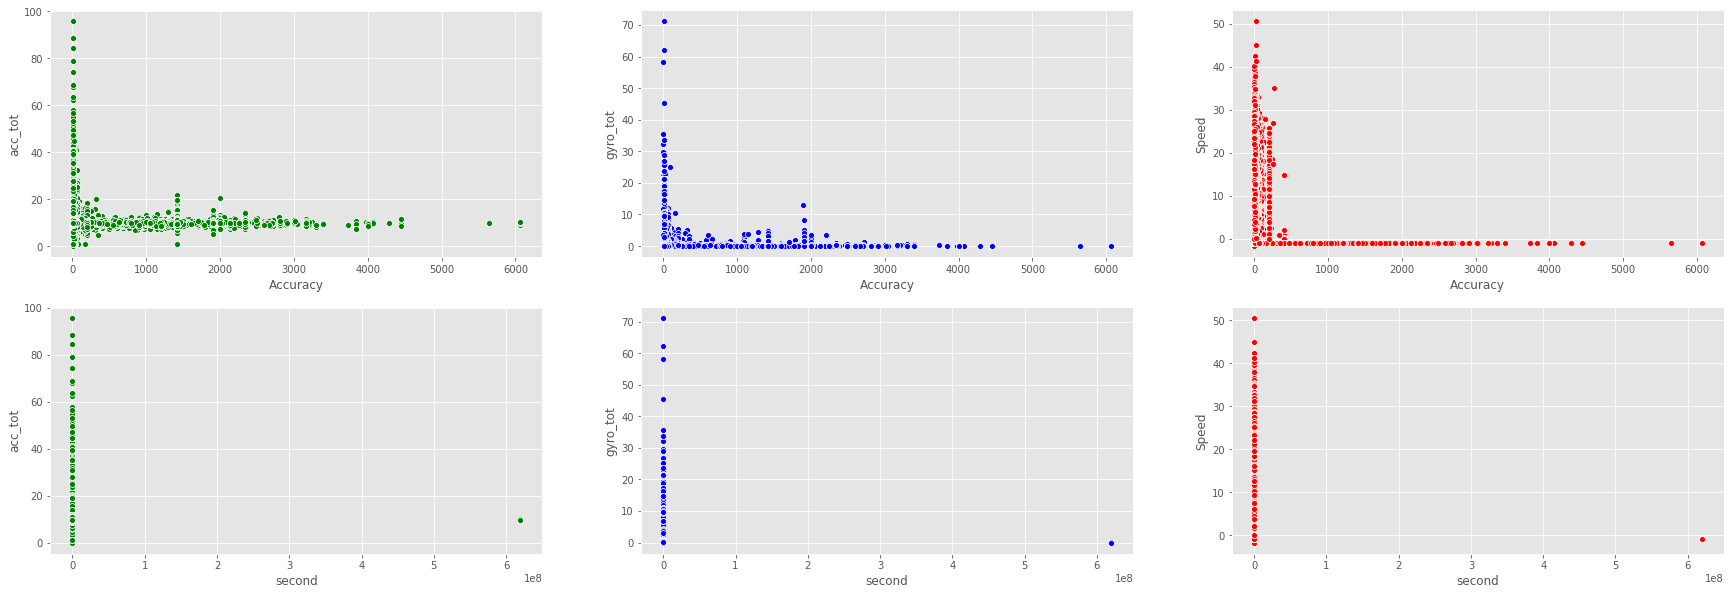

In [12]:
f, ax = plt.subplots(2, 3,figsize=(30,10))
ax[0,0] = sns.scatterplot(x = 'Accuracy',y='acc_tot',data=train,ax=ax[0,0],color='green')
ax[0,1] = sns.scatterplot(x = 'Accuracy',y='gyro_tot',data=train,ax=ax[0,1],color='blue')
ax[0,2] = sns.scatterplot(x = 'Accuracy',y='Speed',data=train,ax=ax[0,2],color='red')
ax[1,0] = sns.scatterplot(x = 'second',y='acc_tot',data=train,ax=ax[1,0],color='green')
ax[1,1] = sns.scatterplot(x = 'second',y='gyro_tot',data=train,ax=ax[1,1],color='blue')
ax[1,2] = sns.scatterplot(x = 'second',y='Speed',data=train,ax=ax[1,2],color='red')
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.close(6)
plt.close(7)

plot above prove that a higher `Accuracy` values (poor accuracy) infer a low value for `acc_tot` , `gyro_tot` and `Speed` features. The obvious thing is that `Speed` tend to close to zero, it means the car is stopped / almost stop and could be in a **must stop** condition such as traffic jam or end of the trips. Another possibilities, the trip surrounded by many building or in the tunnel that makes `Accuracy` poor.

There is some trips with tremendous number of seconds more than 100000000 seconds OR 27777.777778 hours , how could it be? let see it.

In [13]:
train[train['second'] > 10000]

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acc_tot,gyro_tot
88251,858993459333,33.727,0.0,-0.507571,9.758766,1.350330,-0.055894,0.140804,0.113315,619315371.0,-1.0,9.864813,0.189184
91569,1460288880770,5.994,0.0,-0.114922,9.270349,0.804452,-0.202807,-0.043982,-0.012217,619316528.0,-1.0,9.305897,0.207881
150076,1460288880770,5.297,0.0,0.651223,9.385271,1.455675,0.106291,-0.467923,-0.046426,619316508.0,-1.0,9.519789,0.482084
233462,858993459333,16.491,0.0,0.488417,9.806650,-0.402226,-0.039706,0.034514,0.038790,619315480.0,-1.0,9.827040,0.065364
267319,858993459333,25.836,0.0,1.005565,9.241618,0.411803,-0.176540,-0.076358,-0.007330,619315692.0,-1.0,9.305280,0.192486
559691,858993459333,19.012,0.0,0.814029,8.523358,3.667917,-0.030238,0.101709,0.044288,619315826.0,-1.0,9.314714,0.114980
638678,858993459333,21.636,0.0,0.229843,9.911995,1.570596,-0.008858,-0.033598,0.011301,619315821.0,-1.0,10.038289,0.036537
737191,858993459333,24.706,0.0,0.689530,10.400413,1.446098,0.028711,-0.088270,-0.007636,619315786.0,-1.0,10.523081,0.093135
856931,858993459333,28.341,0.0,-0.009577,9.777920,1.302446,-0.056505,0.029322,0.036652,619315577.0,-1.0,9.864288,0.073457
898132,858993459333,31.185,0.0,0.172383,9.672575,1.187524,-0.060781,0.015272,0.020464,619315608.0,-1.0,9.746724,0.065927


All the outlier were in two `bookingID` and all have the same `speed` and `bearing`

In [14]:
label[(label['bookingID'] == 1460288880770) | (label['bookingID'] == 858993459333)]

,bookingID,label
10772,858993459333,0
17387,1460288880770,0


The two data have label `0` , it means it is not dangerous trip, i think it is safe to assumed that these data point is an `outlier` , so it is better to remove them.

In [15]:
# Remove an outlier
removed_index = train[train['second'] > 10000].index
train.drop(removed_index,axis=0,inplace=True)

### Pearson Correlation

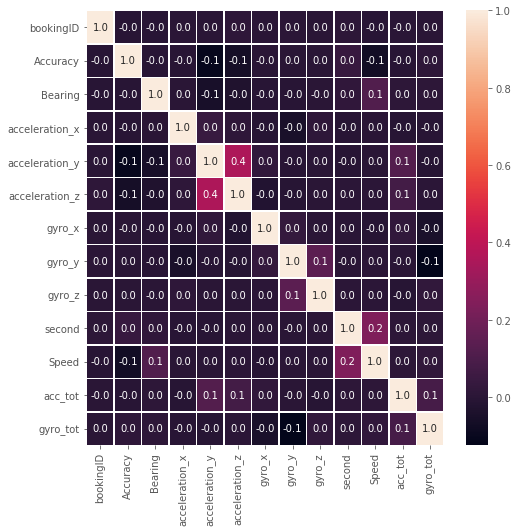

In [16]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Label VS feature distribution

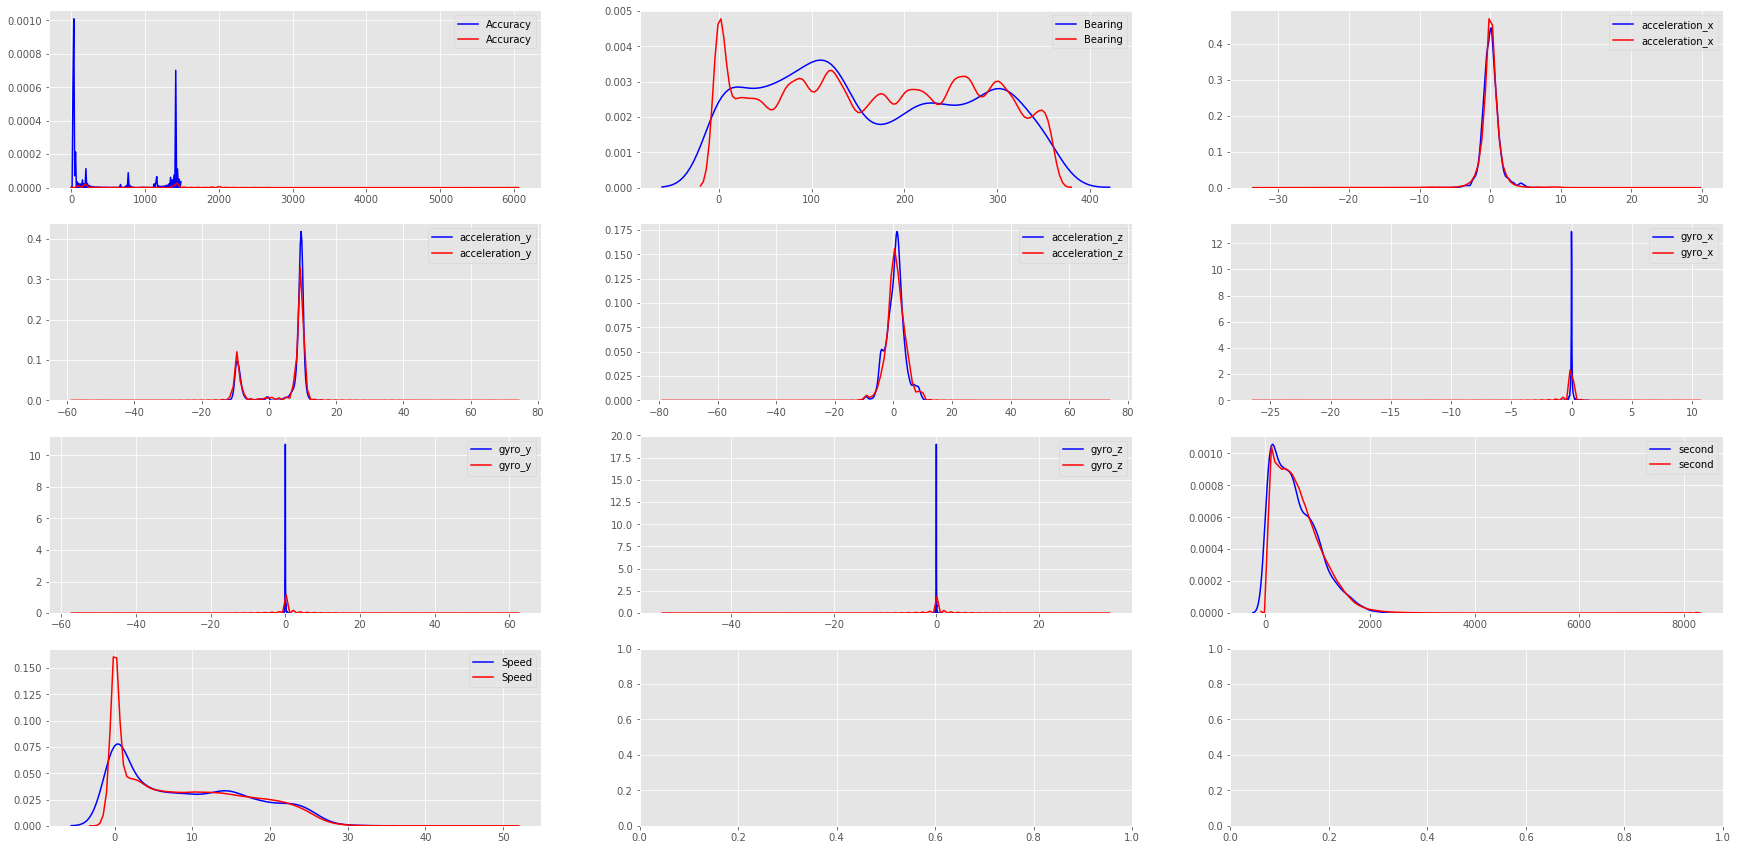

In [17]:
zero = label[label['label'] == 0].bookingID
zero_idx = []
one_idx = []

for idx in range(len(train)):
    if (train['bookingID'].iloc[idx] in zero):
        zero_idx.append(idx)
    else:
        one_idx.append(idx)

f, ax = plt.subplots(4, 3,figsize=(30,15))
cols = ['Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed']
k = 0
for i in range(0,4):
    for j in range(0,3):
        ax[i,j] = sns.kdeplot(train[cols[k]].iloc[zero_idx],label=cols[k],ax=ax[i,j],color='blue')
        ax[i,j] = sns.kdeplot(train[cols[k]].iloc[one_idx],label=cols[k],ax=ax[i,j],color='red')
        k = k + 1
        if (k > 9):
            break
    if (k > 9):
        break

for i in range(4,11):
    plt.close(i)       

The plot tells us a lot!. Distribution at `Accuracy` seems to be highly separated, with one labeled data always having a low `Accuracy` value. The next concern is the `gyro_x` , `gyro_y` and `gyro_z` values with zero-labeled have a fairly high distribution at a peak, then `Bearing` and `Speed` seems to have a little bit different distribution.

## Feature Engineering

### Additional features

Exploration helps us to get an idea about what additional features can we extracted from dataset, with the hope of it can brings addinional value to the model building, here's an idea :
* `Accuracy` seems to have a high impact in separability between zero / one labeled classes. I will create a feature binning that put a high value `Accuracy` (more than 7) into bin `1` else is `0`, and then agregating this feature with sum function and divide by length of the trip. 
* `Bearing` also seems logical to convert into four directions point of compass
* Creating `Acceleration magnitude` that is root of sum of square-root of 3-axis acceleration
* Creating `Gyroscope magnitude` that is root of sum of square-root of 3-axis gyro
* `Roll` , `pitch` and `tilt-angle` of smartphone from acceleration data (source : https://cache.freescale.com/files/sensors/doc/app_note/AN3461.pdf )
* Length of the trips (extracted in aggragation)
* Expected distance ( `mean` of `speed` * `max` of `second` - also extracted in aggregation)
* Count of `negative` value of `speed` divided by length of trip
* Count of high-value `speed` divided by length of trip





In [18]:
train.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acc_tot,gyro_tot
count,1.613543e+06,1.613543e+06,1.613543e+06,1.613543e+06,1.613543e+06,1.613543e+06,1.613543e+06,1.613543e+06,1.613543e+06,1.613543e+06,1.613543e+06,1.613543e+06,1.613543e+06
mean,8.185674e+11,1.157344e+01,1.689123e+02,6.807271e-02,4.469543e+00,8.985273e-01,-1.753923e-03,4.361212e-04,-2.673060e-04,6.020618e+02,9.009831e+00,9.893387e+00,1.293769e-01
std,4.951348e+11,8.665766e+01,1.072635e+02,1.426146e+00,8.129337e+00,3.249642e+00,1.430879e-01,3.460389e-01,1.525670e-01,4.622706e+02,8.106644e+00,1.260886e+00,3.830910e-01
min,0.000000e+00,7.500000e-01,0.000000e+00,-3.344084e+01,-5.730359e+01,-7.844842e+01,-2.644802e+01,-5.734489e+01,-5.355445e+01,0.000000e+00,-1.719776e+00,7.858586e-03,0.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.087678e-01,-1.996386e+00,-9.265844e-01,-2.686464e-02,-2.983076e-02,-1.867217e-02,2.420000e+02,1.020000e+00,9.549027e+00,2.794689e-02
50%,8.074539e+11,4.258000e+00,1.682958e+02,6.130981e-02,9.082092e+00,7.807281e-01,-6.591321e-04,2.746582e-04,-3.051758e-05,5.200000e+02,7.540000e+00,9.818204e+00,6.658206e-02
75%,1.254130e+12,8.000000e+00,2.624500e+02,6.344828e-01,9.710000e+00,2.753416e+00,2.333537e-02,3.141874e-02,1.825615e-02,8.630000e+02,1.548180e+01,1.013485e+01,1.430149e-01
max,1.709397e+12,6.063000e+03,3.599985e+02,2.961647e+01,7.281000e+01,7.331421e+01,1.068810e+01,6.254202e+01,3.383183e+01,8.232000e+03,5.055000e+01,9.563782e+01,7.112736e+01


In [19]:
def preprocessing(data):
    PI = 3.1415926535897932384626433832795
    #sort data by `bookingID` and `second`
    data = data.sort_values(by=['bookingID','second'])
    #Convert acceleration unit to gravitational unit (1g = 9.81 m/s^2)
    data['acceleration_x'] = data['acceleration_x']/9.81
    data['acceleration_y'] = data['acceleration_y']/9.81
    data['acceleration_z'] = data['acceleration_z']/9.81
    #Extract `roll`, `pitch` and `tilt_angle`
    data['roll'] = np.arctan2(data['acceleration_y'] , data['acceleration_z'])*180.0 / PI
    data['pitch'] = np.arctan2((-data['acceleration_x']),np.sqrt(data['acceleration_y']**2 + data['acceleration_z']**2) )*180.0 / PI
    data['tilt_angle'] = np.arccos(data['acceleration_z']  / np.sqrt(data['acceleration_x']**2 + data['acceleration_y']**2 + data['acceleration_z']**2))*180/PI
    data['acc_tot'] = np.sqrt(data['acceleration_x']**2+data['acceleration_y']**2+data['acceleration_z']**2)
    data['gyro_tot'] = np.sqrt(data['gyro_x']**2+data['gyro_y']**2+data['gyro_z']**2)
    #Binning the `Bearing` feature
    data['bearing_bin'] = ''
    idx = data[data['Bearing'] <= 90]['bearing_bin'].index
    data['bearing_bin'].loc[idx] = 'NE'
    idx = data[(data['Bearing'] > 90) & (data['Bearing'] <= 180)]['bearing_bin'].index
    data['bearing_bin'].loc[idx] = 'ES'
    idx = data[(data['Bearing'] > 180) & (data['Bearing'] <= 270)]['bearing_bin'].index
    data['bearing_bin'].loc[idx] = 'SW'
    idx = data[(data['Bearing'] > 270) & (data['Bearing'] <= 360)]['bearing_bin'].index
    data['bearing_bin'].loc[idx] = 'WN'
    #Extract `poor accuracy`
    data['is_poor_accuracy'] = [1 if data['Accuracy'].iloc[i] > 5 else 0 for i in range(len(data))]
    #Extract negative value labeled from `Speed`
    data['is_negative_speed'] = [1 if data['Speed'].iloc[i] < 0 else 0 for i in range(len(data))]
    #Extract high-value labeled from `Speed`
    data['is_high_speed'] = [1 if data['Speed'].iloc[i] > 16 else 0 for i in range(len(data))]
    return data

In [20]:
train = preprocessing(train)
train.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acc_tot,gyro_tot,roll,pitch,tilt_angle,bearing_bin,is_poor_accuracy,is_negative_speed,is_high_speed
436147,0,8.0,143.298294,-0.144414,-0.973296,-0.189702,-0.022413,0.005049,-0.025753,3.0,0.228454,1.002071,0.034511,-101.029070,8.286085,100.912515,ES,1,0,0
314954,0,8.0,143.298294,-0.061445,-0.966863,-0.190388,-0.002221,-0.022451,0.009535,22.0,0.228454,0.987344,0.024493,-101.139767,3.568001,101.117899,ES,1,0,0
1184808,0,12.0,143.298294,0.077649,-1.013004,-0.212079,-0.023960,-0.108738,0.090643,31.0,0.297795,1.037875,0.143577,-101.824466,-4.290615,101.790850,ES,1,0,0
1327390,0,12.0,144.299423,-0.102450,-0.995688,-0.176166,0.001761,0.013517,-0.017036,36.0,0.297795,1.016329,0.021818,-100.033448,5.785455,99.981816,ES,1,0,0
1013616,0,12.0,144.299423,-0.092709,-0.998782,-0.192278,0.001773,0.020846,-0.013098,51.0,0.297795,1.021339,0.024683,-100.896846,5.208045,100.851313,ES,1,0,0


### Agregating Features

For every trips grouped by `bookingID` , i will agregating the features based on simple statistical features and robust statistical properties (source : https://www.kaggle.com/pluceroo/new-features-lgbm-and-simple-rf/notebook , https://www.sciencedirect.com/science/article/pii/S2405896318323127,
https://www.kaggle.com/jesucristo/1-smart-robots-most-complete-notebook#Feature-Engineering)

* `mean`, `median`, `max`, `min`,`range`(max-min), `std-dev`(standard deviation) ,`mad`(mean absolute deviation), `quartile25`, `quartile75`, `quartile95` and `IQR` (inter-quartile range).
* Advance features `CPT5`, `SSC`, `skewness`, `wave length`, `norm entropy`, `SRAV`, `kurtosis` and `mean_abs`
* sum of `bearing_bin` , `is_poor_accuracy`, `is_negative_speed` and `is_high_speed`

In [21]:
def _kurtosis(x):
    return kurtosis(x)

def CPT5(x):
    den = len(x)*np.exp(np.std(x))
    return sum(np.exp(x))/den

def skewness(x):
    return skew(x)

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    xn_i1 = x[0:len(x)-2]  # xn-1
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2),0)
    return sum(ans[1:]) 

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1 
    return sum(abs(xn_i2-xn))
    
def norm_entropy(x):
    tresh = 3
    return sum(np.power(abs(x),tresh))

def SRAV(x):    
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x),2)

def mean_abs(x):
    return sum(abs(x))/len(x)

def zero_crossing(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x,x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    # xn+1
    return sum(np.heaviside(-xn*xn_i2,0))

def mean_change_of_abs_change(x):
    return np.mean(np.diff(np.abs(np.diff(x))))

In [22]:
def all_features(train):
    agg = pd.DataFrame()
    train = pd.get_dummies(train)
    for col in train.columns:
        if col in ['bookingID','bearing_bin','is_high_speed','is_poor_accuracy',
                  'bearing_bin_ES','bearing_bin_NE','bearing_bin_SW','bearing_bin_WN']:
            continue
        agg[str(col)+'_mean'] = train.groupby(['bookingID'])[col].mean()
        agg[str(col)+'_median'] = train.groupby(['bookingID'])[col].median()
        agg[str(col)+'_max'] = train.groupby(['bookingID'])[col].max()
        agg[str(col)+'_min'] = train.groupby(['bookingID'])[col].min()
        agg[str(col)+'_std'] = train.groupby(['bookingID'])[col].std()
        agg[str(col)+'_skew'] = train.groupby(['bookingID'])[col].skew()
        agg[str(col) + '_range'] = agg[str(col) + '_max'] - agg[str(col) + '_min']
        agg[str(col) + '_maxtoMin'] = agg[str(col) + '_max'] / agg[str(col) + '_min']
        agg[str(col) + '_mean_abs_chg'] = train.groupby(['bookingID'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        agg[str(col) + '_mean_change_of_abs_change'] = train.groupby('bookingID')[col].apply(mean_change_of_abs_change)
        agg[str(col) + '_abs_max'] = train.groupby(['bookingID'])[col].apply(lambda x: np.max(np.abs(x)))
        agg[str(col) + '_abs_min'] = train.groupby(['bookingID'])[col].apply(lambda x: np.min(np.abs(x)))
        agg[str(col) + '_abs_avg'] = (agg[col + '_abs_min'] + agg[col + '_abs_max'])/2
        agg[str(col)+'_mad'] = train.groupby(['bookingID'])[col].mad()
        agg[str(col)+'_q25'] = train.groupby(['bookingID'])[col].quantile(0.25)
        agg[str(col)+'_q75'] = train.groupby(['bookingID'])[col].quantile(0.75)
        agg[str(col)+'_q95'] = train.groupby(['bookingID'])[col].quantile(0.95)
        agg[str(col)+'_iqr'] = agg[str(col)+'_q75'] - agg[str(col)+'_q25']
        agg[str(col)+'_cpt5'] = train.groupby(['bookingID'])[col].apply(CPT5)
        agg[str(col)+'_ssc'] = train.groupby(['bookingID'])[col].apply(SSC)
        agg[str(col)+'_mean_abs'] = train.groupby(['bookingID'])[col].apply(mean_abs)
        agg[str(col)+'_skewness'] = train.groupby(['bookingID'])[col].apply(skewness)
        agg[str(col)+'_wave_length'] = train.groupby(['bookingID'])[col].apply(wave_length)
        agg[str(col)+'_norm_entropy'] = train.groupby(['bookingID'])[col].apply(norm_entropy)
        agg[str(col)+'_SRAV'] = train.groupby(['bookingID'])[col].apply(SRAV)
        agg[str(col)+'_kurtosis'] = train.groupby(['bookingID'])[col].apply(_kurtosis)
        agg[str(col)+'_zero_crossing'] = train.groupby(['bookingID'])[col].apply(zero_crossing)
    agg['len'] = train.groupby(['bookingID']).apply(len)
    agg['high_speed'] = train.groupby(['bookingID'])['is_high_speed'].sum() / agg['len']
    agg['negative_speed'] = train.groupby(['bookingID'])['is_negative_speed'].sum()
    agg['dist'] = train.groupby(['bookingID'])['Speed'].mean() * train.groupby(['bookingID'])['second'].max()
    agg['poor_accuracy'] = train.groupby(['bookingID'])['is_poor_accuracy'].sum() / agg['len']
    agg['bearing_bin_ES'] = train.groupby(['bookingID'])['bearing_bin_ES'].sum() / agg['len']
    agg['bearing_bin_NE'] = train.groupby(['bookingID'])['bearing_bin_NE'].sum() / agg['len']
    agg['bearing_bin_SW'] = train.groupby(['bookingID'])['bearing_bin_SW'].sum() / agg['len']
    agg['bearing_bin_WN'] = train.groupby(['bookingID'])['bearing_bin_WN'].sum() / agg['len']
    #Fix missing value and infinity value
    agg.fillna(0, inplace = True)
    agg.replace(-np.inf, 0, inplace = True)
    agg.replace(np.inf, 0, inplace = True)
    return agg

In [23]:
train_agg = all_features(train)

In [24]:
train_agg.head()

,Accuracy_mean,Accuracy_median,Accuracy_max,Accuracy_min,Accuracy_std,Accuracy_skew,Accuracy_range,Accuracy_maxtoMin,Accuracy_mean_abs_chg,Accuracy_mean_change_of_abs_change,...,is_negative_speed_zero_crossing,len,high_speed,negative_speed,dist,poor_accuracy,bearing_bin_ES,bearing_bin_NE,bearing_bin_SW,bearing_bin_WN
bookingID,,,,,,,,,,,,,,,,,,,,,
0,9.736842,8.000,16.000,4.0,3.604453,0.929644,12.000,4.000000,0.955752,0.000000,...,0.0,114,0.271930,0,15426.800547,0.982456,0.157895,0.368421,0.061404,0.412281
1,3.786604,4.000,7.414,3.0,0.700866,1.815909,4.414,2.471333,0.273352,-0.004269,...,0.0,106,0.169811,1,7868.112720,0.028302,0.283019,0.433962,0.141509,0.141509
2,3.845867,3.322,6.000,3.0,1.162913,1.362770,3.000,2.000000,0.566071,0.041308,...,0.0,15,0.000000,0,2548.405255,0.200000,0.133333,0.133333,0.200000,0.533333
4,10.000000,10.000,10.000,10.0,0.000000,0.000000,0.000,1.000000,0.000000,0.000000,...,0.0,110,0.054545,0,6208.092005,1.000000,0.618182,0.081818,0.209091,0.090909
6,4.538825,4.000,12.000,3.0,1.335949,2.154168,9.000,4.000000,0.778451,0.003663,...,0.0,103,0.009709,0,5119.911139,0.223301,0.048544,0.300971,0.145631,0.504854


### Calculate and sort variance

In [25]:
train_agg.var().sort_values()

second_ssc                                      0.000000e+00
gyro_tot_zero_crossing                          0.000000e+00
second_zero_crossing                            0.000000e+00
Bearing_zero_crossing                           0.000000e+00
Accuracy_zero_crossing                          0.000000e+00
tilt_angle_zero_crossing                        0.000000e+00
is_negative_speed_zero_crossing                 0.000000e+00
acc_tot_zero_crossing                           0.000000e+00
acc_tot_mean_change_of_abs_change               7.303942e-06
gyro_z_abs_min                                  9.380578e-06
acceleration_y_mean_change_of_abs_change        1.053503e-05
acceleration_x_mean_change_of_abs_change        1.150240e-05
acceleration_z_mean_change_of_abs_change        1.574214e-05
is_negative_speed_mean_change_of_abs_change     1.978841e-05
gyro_x_mean_change_of_abs_change                2.913174e-05
gyro_z_mean_change_of_abs_change                5.780374e-05
gyro_x_abs_min          

it looks like `zero_crossing` and several `cpt5` feature extraction doesn't do a good job, resulting zero and infinity variance value, lets clean this first

In [26]:
cols = ['Bearing_zero_crossing','gyro_tot_zero_crossing','Accuracy_zero_crossing',
        'tilt_angle_zero_crossing','acc_tot_zero_crossing','second_zero_crossing',
        'second_ssc','is_negative_speed_zero_crossing','roll_cpt5','tilt_angle_cpt5',
       'second_cpt5','Accuracy_cpt5','Bearing_cpt5']
train_agg.drop(cols,axis=1,inplace=True)

In [27]:
train_agg = pd.merge(train_agg,label,on='bookingID')
train_agg.head()

,bookingID,Accuracy_mean,Accuracy_median,Accuracy_max,Accuracy_min,Accuracy_std,Accuracy_skew,Accuracy_range,Accuracy_maxtoMin,Accuracy_mean_abs_chg,...,len,high_speed,negative_speed,dist,poor_accuracy,bearing_bin_ES,bearing_bin_NE,bearing_bin_SW,bearing_bin_WN,label
0,0,9.736842,8.000,16.000,4.0,3.604453,0.929644,12.000,4.000000,0.955752,...,114,0.271930,0,15426.800547,0.982456,0.157895,0.368421,0.061404,0.412281,0
1,1,3.786604,4.000,7.414,3.0,0.700866,1.815909,4.414,2.471333,0.273352,...,106,0.169811,1,7868.112720,0.028302,0.283019,0.433962,0.141509,0.141509,1
2,2,3.845867,3.322,6.000,3.0,1.162913,1.362770,3.000,2.000000,0.566071,...,15,0.000000,0,2548.405255,0.200000,0.133333,0.133333,0.200000,0.533333,1
3,4,10.000000,10.000,10.000,10.0,0.000000,0.000000,0.000,1.000000,0.000000,...,110,0.054545,0,6208.092005,1.000000,0.618182,0.081818,0.209091,0.090909,1
4,6,4.538825,4.000,12.000,3.0,1.335949,2.154168,9.000,4.000000,0.778451,...,103,0.009709,0,5119.911139,0.223301,0.048544,0.300971,0.145631,0.504854,0


## Modelling

First,lets see how aggregated dataset perform accross different algorithm with default parameter that is `Linear regression` , `Random Forest` , `LightGBM` and `XGBoost`. Model evaluated using 5-fold Stratified cross-validation and AUC metric

In [28]:
X = train_agg.drop(['bookingID','label'],axis=1)
y = train_agg['label']
scaler = StandardScaler()
#Scaling features
X = scaler.fit_transform(X)
skf = StratifiedKFold(n_splits=5, random_state=7)
model = LogisticRegression()
res_lr = cross_val_score(model,X,y,cv=skf,scoring='roc_auc')
print(f"StratifiedCV LogisticRegression Scores : {res_lr}")
print(f"mean StratifiedCV LogisticRegression Scores : {res_lr.mean()}")

StratifiedCV LogisticRegression Scores : [0.7152381  0.72015767 0.73209833 0.727996   0.72228843]
mean StratifiedCV LogisticRegression Scores : 0.7235557049429174


In [29]:
X = train_agg.drop(['bookingID','label'],axis=1)
y = train_agg['label']
skf = StratifiedKFold(n_splits=5, random_state=7)
model = RandomForestClassifier()
res_rf = cross_val_score(model,X,y,cv=skf,scoring='roc_auc')
print(f"StratifiedCV RandomForest Scores : {res_rf}")
print(f"mean StratifiedCV RandomForest Scores : {res_rf.mean()}")

StratifiedCV RandomForest Scores : [0.6649021  0.66853083 0.67108783 0.67974217 0.67374125]
mean StratifiedCV RandomForest Scores : 0.6716008356635584


In [30]:
X = train_agg.drop(['bookingID','label'],axis=1)
y = train_agg['label']
skf = StratifiedKFold(n_splits=5, random_state=7)
model = xgb.XGBClassifier()
res_xgb = cross_val_score(model,X,y,cv=skf,scoring='roc_auc')
print(f"StratifiedCV XGBoost Scores : {res_xgb}")
print(f"mean StratifiedCV XGBoost Scores : {res_xgb.mean()}")

StratifiedCV XGBoost Scores : [0.7275631  0.73592067 0.741182   0.73696167 0.74070757]
mean StratifiedCV XGBoost Scores : 0.7364670012172334


In [31]:
X = train_agg.drop(['bookingID','label'],axis=1)
y = train_agg['label']
skf = StratifiedKFold(n_splits=5, random_state=7)
model = lgb.LGBMClassifier()
res_lgb = cross_val_score(model,X,y,cv=skf,scoring='roc_auc')
print(f"StratifiedCV LGBM Scores : {res_lgb}")
print(f"mean StratifiedCV LGBM Scores : {res_lgb.mean()}")

StratifiedCV LGBM Scores : [0.71816417 0.73081133 0.734126   0.727005   0.73140547]
mean StratifiedCV LGBM Scores : 0.7283023941974


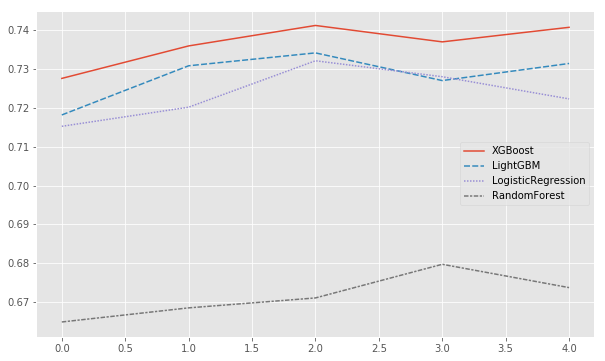

In [32]:
res = pd.DataFrame()
res['XGBoost'] = res_xgb
res['LightGBM'] = res_lgb
res['LogisticRegression'] = res_lr
res['RandomForest'] = res_rf
plt.figure(figsize=(10,6))
sns.lineplot(data = res)

The results put `Random Forest` into the bottom place and `Logistic regression` do the job really well consider how simple it is compared to others.

### Feature Selection With Eli5 Permutation Importance

One way to measure features performance againts the model is using feature importance. The problem with standard feature importance is, the result seems unstable when we run the algorithm multiple times. Permutation importance measure how big is the effect to the metrics results if we shuffle spesific features in the validation set. So, it is calculated **after the model has been fitted**. Based on experiment above, XGBoost seems to be the most stable and high metrics value so far.

In [33]:
#Calculated permutation importance using XGBoost
X = train_agg.drop(['bookingID','label'],axis=1)
perm = PermutationImportance(xgb.XGBClassifier(), cv=skf)
perm.fit(X.values,y)

PermutationImportance(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=False),
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
           n_iter=5, random_state=None, refit=True, scoring=None)

Lets put the result in the form `pandas dataframe` for better visualization

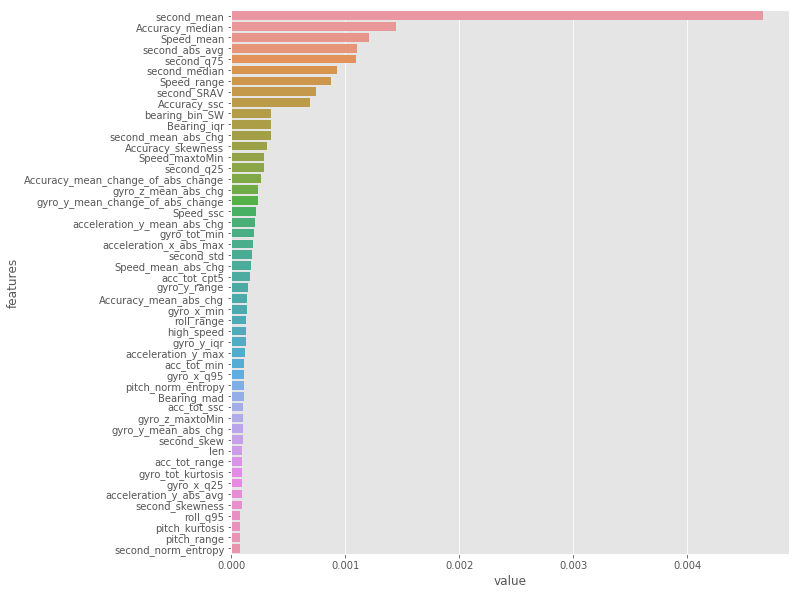

In [34]:
importances = pd.DataFrame()
importances['features'] = X.columns
importances['value'] = perm.feature_importances_
importances = importances.sort_values(by=['value'],ascending=False)
importances = importances.reset_index()
#Top 50 features
plt.figure(figsize=(10,10))
data = importances.head(50)
sns.barplot(x='value',y='features',data=data)

In the Top 50, there are a bunch of `second` , `Speed` and `Accuracy` features , it matched the exploration before, especially the `Accuracy`. Next, lets we select top-K feature to reduce the bias from un-important features.

In [35]:
len(X.columns)

428

experiment 0 finished!
experiment 1 finished!
experiment 2 finished!
experiment 3 finished!
experiment 4 finished!
experiment 5 finished!
experiment 6 finished!
experiment 7 finished!
experiment 8 finished!
experiment 9 finished!
experiment 10 finished!
experiment 11 finished!
experiment 12 finished!
experiment 13 finished!


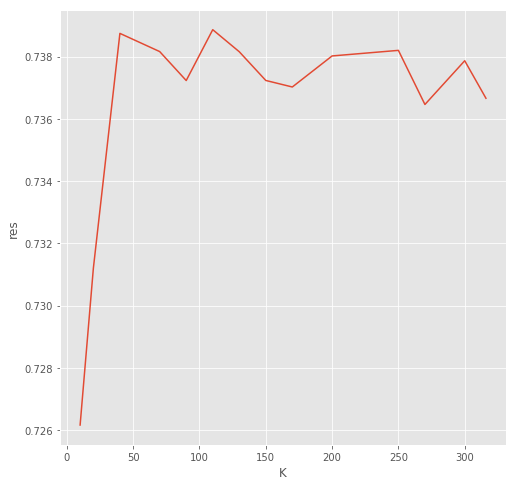

In [36]:
#Tune the number of features
K = [10, 20, 40, 70, 90, 110, 130, 150, 170, 200, 250, 270, 300, 316]
res = []
data = pd.DataFrame()
data['K'] = K
for idx, val in enumerate(K):
    X = train_agg.drop(['bookingID','label'],axis=1)[importances[:val]['features']] # select K-best features
    y = train_agg['label']
    skf = StratifiedKFold(n_splits=5, random_state=7)
    model = xgb.XGBClassifier()
    res_xgb = cross_val_score(model,X,y,cv=skf,scoring='roc_auc')
    res.append(res_xgb.mean())
    print(f'experiment {idx} finished!')
data['res'] = res
plt.figure(figsize=(8,8))
sns.lineplot(x='K',y='res',data=data)

The result shows that taking top-130 features is the highest CV value, with mean AUC `0.738`, The next step is to tune the `n_estimators` for the XGBoost model, as in my experience `n_estimators` is the most impactful parameter to the tree-based model, the better way is to do a `GridSearch` for many set of parameters but it is very time consuming and usually get a small of improvement compared to default parameter.

experiment 0 finished!
experiment 1 finished!
experiment 2 finished!
experiment 3 finished!
experiment 4 finished!
experiment 5 finished!
experiment 6 finished!
experiment 7 finished!


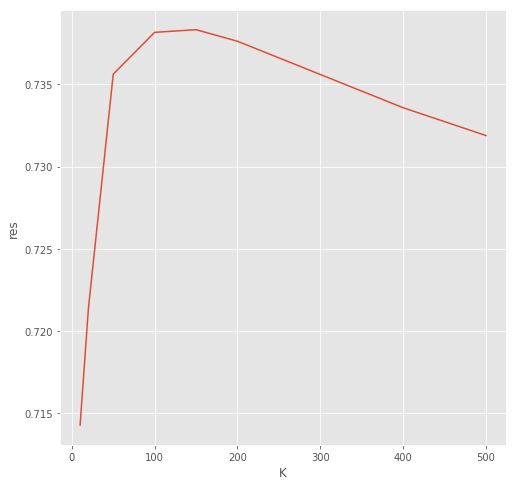

In [37]:
#Tune the number of n_estimators
K = [10, 20, 50, 100, 150, 200, 400, 500]
res = []
data = pd.DataFrame()
data['K'] = K
for idx, val in enumerate(K):
    X = train_agg.drop(['bookingID','label'],axis=1)[importances[:130]['features']] # select K-best features
    y = train_agg['label']
    skf = StratifiedKFold(n_splits=5, random_state=7)
    model = xgb.XGBClassifier(n_estimators = val) #fine-tuned n_estimators
    res_xgb = cross_val_score(model,X,y,cv=skf,scoring='roc_auc')
    res.append(res_xgb.mean())
    print(f'experiment {idx} finished!')
data['res'] = res
plt.figure(figsize=(8,8))
sns.lineplot(x='K',y='res',data=data)

plot tells that result are converge at `n_estimators` = 150

### Weighted ensemble model

Lets see if simple weighting ensemble model helps smoothing the result. after doing some manual tuning, this is the optimal weight combination :
* 0.75 * xgb + 0.10 * LGBM + 0.10 * LR + 0.05 * RF

In [39]:
skf = StratifiedKFold(n_splits=5, random_state=7)
score = []
scaler = StandardScaler()
X = train_agg.drop(['bookingID','label'],axis=1)[importances[:130]['features']]
y = train_agg['label']
X_scaling = scaler.fit_transform(X)
model_xgb = xgb.XGBClassifier(n_estimators = 150)
model_lgb = lgb.LGBMClassifier()
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()
i = 1
for train_index, test_index in skf.split(X_scaling,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_xgb.fit(X_train,y_train)
    model_lgb.fit(X_train,y_train)
    model_lr.fit(X_train,y_train)
    model_rf.fit(X_train,y_train)
    predict_xgb = model_xgb.predict_proba(X_test)[:,1]*0.75
    predict_lgb = model_lgb.predict_proba(X_test)[:,1]*0.10
    predict_rf = model_rf.predict_proba(X_test)[:,1]*0.05
    predict_lr = model_lr.predict_proba(X_test)[:,1]*0.10
    tot = predict_xgb + predict_lgb + predict_rf + predict_lr 
    val = roc_auc_score(y_test,tot)
    score.append(val)
    print(f"Score AUC in CV-{i} : {val}")
    i = i + 1

Score AUC in CV-1 : 0.7304219114219114
Score AUC in CV-2 : 0.7408813333333334
Score AUC in CV-3 : 0.7427523333333333
Score AUC in CV-4 : 0.7377786666666666
Score AUC in CV-5 : 0.7419596532177393


In [40]:
np.mean(score)

0.7387587795945967

The mean - AUC value going up from `0.736` to `0.7387` , not a very big jump , but it helps to make prediction much more smooth.

### Unsuccesfull attemp

several thingss i've tried to higher up AUC value, unfortunately it didn't work.
* 1 - level stacking classifier of `random forest` , `xgboost` , `lightGBM` , `SVM` and `Logistic regression` not helping the AUC value to go up
* Gaussian Optimization for tuning parameter also un-successful to get an optimal parameter than default parameter with modified `n_estimators`
* Denoising the signal with `FFT` unfortunately also didn't work, i think it is mainly because the frequency of taking data point is different and the length of the signal is also varies.


In [48]:
from numpy.fft import *
import pyarrow.parquet as pq

def filter_signal(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=7/signal.size)
    fourier[frequencies > threshold] = 0
    if (len(signal) != len(irfft(fourier))):
        res = irfft(fourier)
        res = np.append(res,signal.values[-1])
        return res
    return irfft(fourier)

In [49]:
# https://www.kaggle.com/theoviel/fast-fourier-transform-denoising
temp = train[train['bookingID'] == 335007449205].sort_values(by='second')
filtered_acc_x = filter_signal(temp['acceleration_x'], threshold=1.5)
filtered_acc_y = filter_signal(temp['acceleration_y'], threshold=1.5)
filtered_acc_z = filter_signal(temp['acceleration_z'], threshold=1.5)
filtered_gyro_x = filter_signal(temp['gyro_x'], threshold=1.5)
filtered_gyro_y = filter_signal(temp['gyro_y'], threshold=1.5)
filtered_gyro_z = filter_signal(temp['gyro_z'], threshold=1.5)

Text(0.5, 1.0, 'gyro_z')

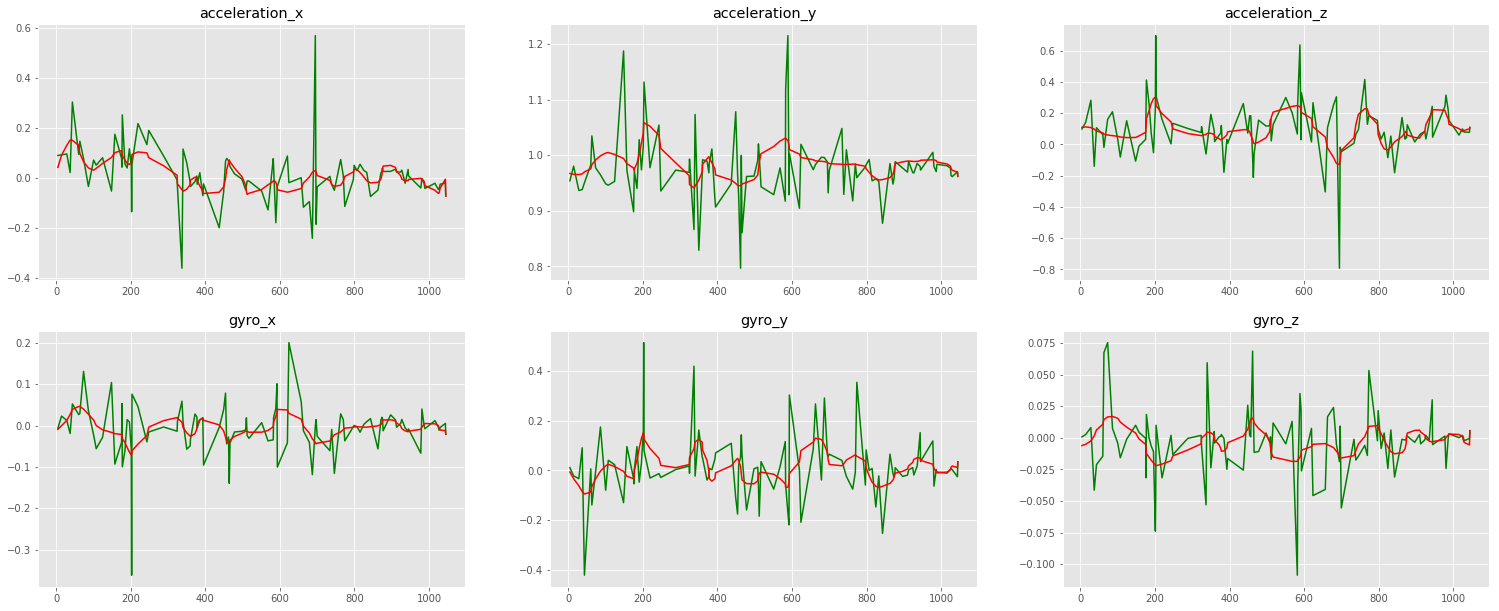

In [50]:
plt.figure(figsize=(26, 16))
plt.subplot(3, 3, 1)
plt.plot(temp['second'],temp['acceleration_x'], color='green')
plt.plot(temp['second'],filtered_acc_x, color='red')
plt.title('acceleration_x')

plt.subplot(3, 3, 2)
plt.plot(temp['second'],temp['acceleration_y'], color='green')
plt.plot(temp['second'],filtered_acc_y, color='red')
plt.title('acceleration_y')

plt.subplot(3, 3, 3)
plt.plot(temp['second'],temp['acceleration_z'], color='green')
plt.plot(temp['second'],filtered_acc_z, color='red')
plt.title('acceleration_z')

plt.subplot(3, 3, 4)
plt.plot(temp['second'],temp['gyro_x'], color='green')
plt.plot(temp['second'],filtered_gyro_x, color='red')
plt.title('gyro_x')

plt.subplot(3, 3, 5)
plt.plot(temp['second'],temp['gyro_y'], color='green')
plt.plot(temp['second'],filtered_gyro_y, color='red')
plt.title('gyro_y')

plt.subplot(3, 3, 6)
plt.plot(temp['second'],temp['gyro_z'], color='green')
plt.plot(temp['second'],filtered_gyro_z, color='red')
plt.title('gyro_z')

Text(0.5, 1.0, 'acceleration_x')

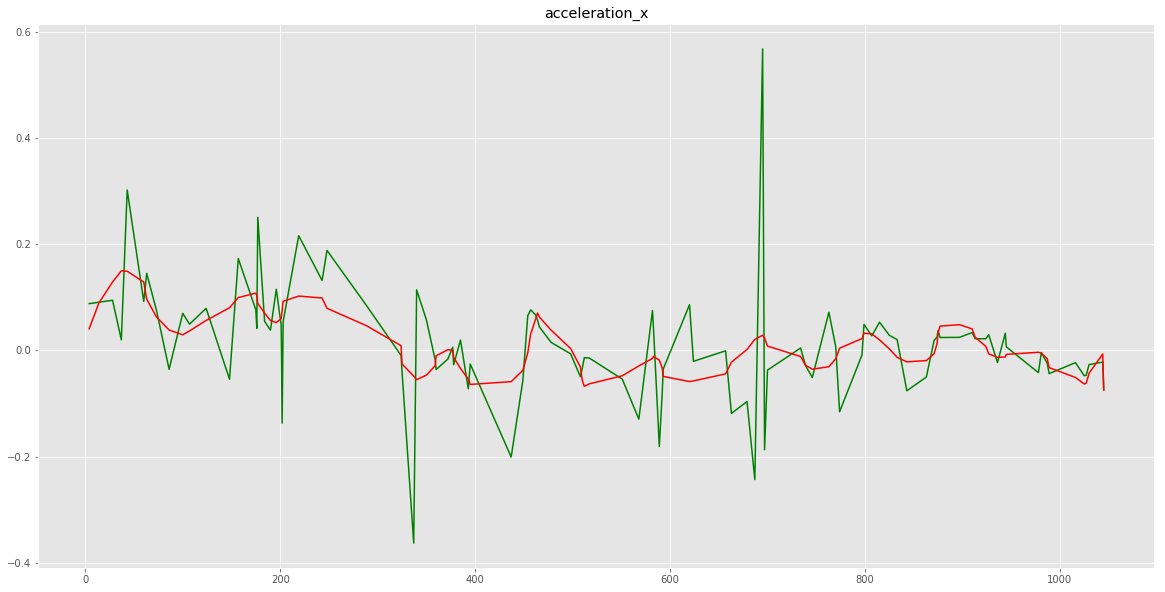

In [51]:
plt.figure(figsize=(20,10))
plt.plot(temp['second'],temp['acceleration_x'], color='green')
plt.plot(temp['second'],filtered_acc_x, color='red')
plt.title('acceleration_x')

As we can see, denoising really doesn't make a signal smoother.

## Making Prediction

In [ ]:
test_name = ['part-00001-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv',
            'part-00002-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv',
            'part-00003-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv',
            'part-00004-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv',
            'part-00005-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv',
            'part-00006-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv',
            'part-00007-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv',
            'part-00008-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv',
            'part-00009-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv']
i = 1

del model_xgb,model_lgb,model_lr,model_rf

model_xgb = xgb.XGBClassifier(n_estimators = 150)
model_lgb = lgb.LGBMClassifier()
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()

scaler = StandardScaler()
train_agg = train_agg.reindex(sorted(train_agg.columns), axis=1)

X = train_agg.drop(['bookingID','label'],axis=1)[importances[:130]['features']]
y = train_agg['label']
X_scaling = scaler.fit_transform(X)

model_xgb.fit(X_scaling,y)
model_lgb.fit(X_scaling,y)
model_lr.fit(X_scaling,y)
model_rf.fit(X_scaling,y)

result = pd.DataFrame()
for name in test_name:
    test = pd.read_csv("../Documents/safety/features/"+str(name))
    test = preprocessing(test)
    test = all_features(test)
    test = test.reset_index()
    result['bookingID'] = test['bookingID']
    test = test[importances[:130]]['features']
    test = test.reindex(sorted(test.columns), axis=1)
    predict_xgb = model_xgb.predict_proba(test.values)[:,1]*0.75
    predict_lgb = model_lgb.predict_proba(test.values)[:,1]*0.10
    predict_rf = model_rf.predict_proba(test.values)[:,1]*0.05
    predict_lr = model_lr.predict_proba(test.values)[:,1]*0.10
    tot = predict_xgb + predict_lgb + predict_rf + predict_lr
    result['label'] = np.argmax(tot)
    result.to_csv('result_'+str(i)+'.csv',index=False)
    print(f"test {i} predicted!")
    i = i + 1
    del test

## Conclusion

* `Second` , `Accuracy` and `Speed` is the three most important features according to permutation importance, this matched a hypothesis getting from exploration step. higher `Accuracy`, `Speed` and `Second` value are more likely to be labeled as an unsafe trips. This is quite obvious as this three features describe core things in trips, `Second` as a time , `Accuracy` as a location and `Speed` as how is the driver behaviour.

* `0.738` is the highest mean AUC value from weighting four models with 5-fold Stratified Cross Validation, more advanced model like multi-level stacking with dozens of model maybe help to rise the AUC value, my machine is limited to only try basic model with a little bit optimization. The results quite good compared to plain `LightGBM`, `RandomForest` and `LogisticRegression`

* better collecting data train method is needed to make 3-axis gyro and accelerometer data more useful because It has a lot of potential, and also it is better to collect the orientation data (which is not present in this dataset) to create better feature e.g `euler angle`

Thanks for Reading !!